In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [3]:
path = r"C:\Ibrahim\Personal\University Stuff\Machine Learning\Project\ML Irrigation Project\data\raw\Rain_fall_in_Pakistan.csv"

df = pd.read_csv(path)
df = df.iloc[1:].copy() #removing metadata row
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.head()

,date,adm2_id,ADM2_PCODE,n_pixels,rfh,rfh_avg,r1h,r1h_avg,r3h,r3h_avg,rfq,r1q,r3q,version
1,1981-01-01,1009036,PK401,36.0,33.9444,20.9926,NaN,NaN,NaN,NaN,149.829,NaN,NaN,final
2,1981-01-11,1009036,PK401,36.0,7.9167,21.4537,NaN,NaN,NaN,NaN,48.8274,NaN,NaN,final
3,1981-01-21,1009036,PK401,36.0,95.9167,29.4389,137.7778,71.8852,NaN,NaN,293.0311,180.4695,NaN,final
4,1981-02-01,1009036,PK401,36.0,52.1667,33.8259,156.0,84.7185,NaN,NaN,147.2384,175.2561,NaN,final
5,1981-02-11,1009036,PK401,36.0,17.3889,33.8713,165.4722,97.1361,NaN,NaN,57.5975,163.7844,NaN,final


In [4]:
non_numeric = ['date', 'adm2_id', 'ADM2_PCODE', 'version']
numeric_cols = [c for c in df.columns if c not in non_numeric]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

we will create sequences like:

X shape: (regions * sequences_per_region, seq_len, 1)

y shape: (regions * sequences_per_region)

that means:

- we generate sliding windows for each region separately

- then we stack all regions into one big training set

- the LSTM learns general rainfall patterns

- we get ONE strong model that predicts any region

- our dashboard can choose a region and forecast future rainfall

In [6]:
region_id = str(df['adm2_id'].unique()[0])
df_region = df[df['adm2_id'] == region_id].sort_values('date').reset_index(drop=True)

df_region.head(10)

,date,adm2_id,ADM2_PCODE,n_pixels,rfh,rfh_avg,r1h,r1h_avg,r3h,r3h_avg,rfq,r1q,r3q,version
0,1981-01-01,1009036,PK401,36.0,33.9444,20.9926,NaN,NaN,NaN,NaN,149.8290,NaN,NaN,final
1,1981-01-11,1009036,PK401,36.0,7.9167,21.4537,NaN,NaN,NaN,NaN,48.8274,NaN,NaN,final
2,1981-01-21,1009036,PK401,36.0,95.9167,29.4389,137.7778,71.8852,NaN,NaN,293.0311,180.4695,NaN,final
3,1981-02-01,1009036,PK401,36.0,52.1667,33.8259,156.0000,84.7185,NaN,NaN,147.2384,175.2561,NaN,final
4,1981-02-11,1009036,PK401,36.0,17.3889,33.8713,165.4722,97.1361,NaN,NaN,57.5975,163.7844,NaN,final
5,1981-02-21,1009036,PK401,36.0,37.0833,18.9009,106.6389,86.5981,NaN,NaN,176.0741,120.7465,NaN,final
6,1981-03-01,1009036,PK401,36.0,45.7222,21.6231,100.1944,74.3954,NaN,NaN,190.5193,130.5693,NaN,final
7,1981-03-11,1009036,PK401,36.0,81.8333,24.9417,164.6389,65.4657,NaN,NaN,290.0083,231.4148,NaN,final
8,1981-03-21,1009036,PK401,36.0,41.9167,27.4315,169.4722,73.9963,413.8889,232.4796,144.6640,213.6668,174.8142,final
9,1981-04-01,1009036,PK401,36.0,4.7500,27.6361,128.5000,80.0093,384.6944,239.1231,29.8749,153.8731,158.4335,final


In [7]:
#extracting rainfall column
rain_series = df_region['rfh'].values.reshape(-1,1)
rain_series[:10]

array([[33.9444],
       [ 7.9167],
       [95.9167],
       [52.1667],
       [17.3889],
       [37.0833],
       [45.7222],
       [81.8333],
       [41.9167],
       [ 4.75  ]])

In [8]:
#scale to 0-1 using MinMaxScaler
#neural networks train much better on normalised data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
rain_scaled = scaler.fit_transform(rain_series)
rain_scaled[:10]

array([[0.12147891],
       [0.02550458],
       [0.34999506],
       [0.18867167],
       [0.0604323 ],
       [0.13305326],
       [0.16490827],
       [0.29806405],
       [0.1508759 ],
       [0.01382772]])

LSTMs learn best when everything is in a small range, usually 0–1.

In [9]:
#creating sliding window sequences for LSTM
#use past 30 time steps (30 hrs for now)

#helper function
def create_sequences(data, seq_length=30):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [10]:
#creating sequences from scaled rainfall
SEQ_LEN = 30
X, y = create_sequences(rain_scaled, SEQ_LEN)
X.shape, y.shape

((1539, 30, 1), (1539, 1))

- **1539 sequences** where each is **30** time steps long

- **30** -> LSTM input window

- **1** -> one rainfall value at each timestep

- *y* -> the target val (rainfall at the next time step)

In [11]:
#train/validation/test split (chronological)
#we wont shuffle, since we're dealing with a time-series
# [ TRAIN | VALIDATION | TEST ]

train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

In [13]:
print(f"X_train.shape: {X_train.shape}\nX_val.shape: {X_val.shape}\nX_test.shape: {X_test.shape}")

X_train.shape: (1077, 30, 1)
X_val.shape: (230, 30, 1)
X_test.shape: (232, 30, 1)


- 1077 training sequences

- 230 validation sequences

- 232 test sequences

- sequence length = how many past timesteps the model looks at, we used SEQ_LEN = 30, that means: each input contains 30 hours of rainfall values

- a single training example looks like:

[
  
    rfh(t - 30),

    rfh(t - 29),
  
    rfh(t - 28),
  
    ...
  
    rfh(t - 1)

]


- **30 values** → representing 30 hours before the prediction.

- **1**: this is the number of features per timestep. we are using only one feature: *rfh* (rainfall for current hour)

### **building the model: model architecture**

LSTM(32 units)

↓

Dense(1 unit)

### **LSTM(32 units):**

this is the recurrent neural network layer.

#### **what LSTM does:**

it receives sequence shaped like (30 timesteps, 1 feature), it reads it step-by-step (hour-by-hour rainfall), it learns short-term and long-term temporal patterns; it creates a compressed representation of the last 30 hours (like a memory summary)

#### **what 32 units means:**

an LSTM layer has “neurons,” just like dense layers. each of the 32 units learns a different rule or pattern.
**examples:**
- “Rainfall usually increases 4–6 hours after a drop”
- “This region has small peaks every morning”
- “If the last 12 hours are rising, expect more rise”

we don’t manually define these patterns - the LSTM learns them.

#### **output of the LSTM:**

after reading 30 hourly values, it outputs a vector of size 32: 

[0.12, -0.41, 0.23, ... 32 values ...]

this vector represents the LSTM’s learned understanding of the last 30 hours.

### **Dense(1 unit)**

this is the final prediction layer.

#### **Why 1 unit?**

because our task is:

-> Predict the rainfall value for the next hour

that next value is one number, so:

- 1 output neuron
- a regression problem
- no activation function required (we want raw numbers)

#### **what Dense(1) does:**

it takes the 32 learned features from the LSTM and turns them into a single prediction:

[0.12, 0.33, -0.27, ...] → 0.057

this output is your next-hour rainfall prediction (scaled).

In [ ]:
#build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

model = Sequential([
    Input(shape=(SEQ_LEN, 1)),
    LSTM(32, return_sequences=False),
    Dense(1)
])

In [19]:
#compile the model

#using:
#- Adam optimizer (standard)
#- MSE loss (for regression)
#- MAE metric (for readability)

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

#### **Adam Optimizer**
- Adam is the default, go-to optimizer for deep learning.
- adjusts learning rate automatically while training.
- helps the model converge faster and more smoothly.
- 95% of LSTM tutorials use Adam.
- helps model learn efficiently without tuning too much.
#### **MSE Loss (mean squared error)**
- main objective the model tries to minimize.
- punishes large errors more than small ones.
- it’s the standard loss for regression tasks (predicting numbers).
- measures how far predicted rainfall is from the real rainfall.
#### **MAE Metrics (mean absolute error)**
- not used for training, only used for reporting
- MAE is easier to interpret than MSE
- MAE = *"on average, how many units was the model wrong?"*
- MAE tells us, in normal numbers, how off the predictions were

In [20]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#training the model
#adding early stopping so training stops when there is no improvement
#if the validation loss stops improving, for 5 consecutive epochs, then training automatically stops
#preventing overfitting, wasting time on training, and stopping the model from getting worse

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    batch_size = 32,
    epochs = 50,
    callbacks = [early_stop],
    verbose = 1
)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0213 - mae: 0.0959 - val_loss: 0.0207 - val_mae: 0.0927
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0179 - mae: 0.0882 - val_loss: 0.0180 - val_mae: 0.0897
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0163 - mae: 0.0829 - val_loss: 0.0163 - val_mae: 0.0801
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0146 - mae: 0.0805 - val_loss: 0.0161 - val_mae: 0.0848
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0138 - mae: 0.0766 - val_loss: 0.0152 - val_mae: 0.0848
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0135 - mae: 0.0766 - val_loss: 0.0179 - val_mae: 0.0868
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0137 - mae: 0.0762 - val_loss: 0.0160 - val_mae: 0.0780
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0133 - mae: 0.0744 - val_loss: 0.0164 - val_mae: 0.0820
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0129 - mae:

#### **EarlyStopping() parameters**
- **monitor='val_loss'** → “watch the validation loss to decide when to stop training.”

- **patience=5** → “stop training if validation loss doesn't improve for 5 consecutive epochs.”

- **restore_best_weights=True** → “after stopping, load the weights from the epoch where validation loss was lowest.”

#### **model.fit() parameters**
- **X_train, y_train** → “Training input data and target values.”

- **validation_data=(X_val, y_val)** → “use this validation set to evaluate performance after each epoch.”

- **batch_size=32** → “Train on 32 samples at a time before updating the weights.”

- **epochs=50** → “Allow up to 50 training passes through the entire dataset.”

- **callbacks=[early_stop]** → “Apply EarlyStopping during training.”

- **verbose=1** → “Print training progress and metrics.”

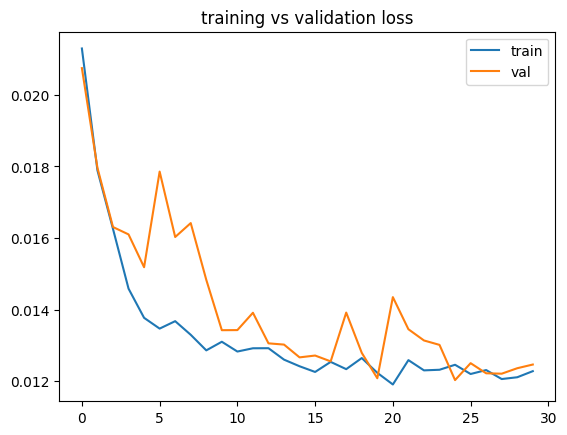

In [23]:
#plot training and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.title("training vs validation loss")
plt.show()

- y-axis -> error
- x-axis -> epoch number
1. both lines are going down that means the model is learning
- the model's error decreases steadily during training
- validation loss also decreases overall
this means that LSTM is successfully learning the rainfall patterns from the region
2. validation loss stays close to training loss
- training loss approx. 0.012
- validation loss approx. 0.013
- this means that model is generalizing well, and is not overfitting
3. Validation loss jiggles a bit → Normal
- time series data often has small fluctuations.
- validation loss follows the training loss trend (downward), just slightly noisier.
4. Model converged around epoch ~20-25
- after epoch ~20, the loss values stop improving meaningfully.
- they hover around a stable error level.

##### LSTM model learned the rainfall pattern well, did not overfit, and reached its best performance around epoch 20 - the loss curves show healthy learning behaviour.

In [24]:
#evaluate LSTM on test data

#making predictions on the test set
y_pred_scaled = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [25]:
#reshaping for inverse scaling
y_test_scaled = y_test.reshape(-1,1)
y_pred_scaled = y_pred_scaled.reshape(-1,1)

#inverse scaling
y_test_actual = scaler.inverse_transform(y_test_scaled)
y_pred_actual = scaler.inverse_transform(y_pred_scaled)

#both should be now in millimeters of rainfall

In [26]:
y_test_actual

array([[ 13.7778],
       [ 23.5   ],
       [ 14.7778],
       [ 10.8333],
       [ 46.    ],
       [ 62.75  ],
       [  3.0278],
       [ 53.9167],
       [ 50.8889],
       [  5.5556],
       [ 20.9444],
       [ 16.7222],
       [ 18.7222],
       [ 55.1111],
       [128.6944],
       [148.3333],
       [ 99.6944],
       [ 79.8611],
       [ 88.8056],
       [ 15.6111],
       [ 51.7778],
       [ 18.6111],
       [ 42.8889],
       [ 20.1111],
       [  4.9722],
       [ 13.6944],
       [  6.3056],
       [  4.0833],
       [ 20.9444],
       [  4.9167],
       [  4.2778],
       [ 25.1667],
       [ 39.6667],
       [ 65.1944],
       [ 36.4722],
       [ 60.6389],
       [ 10.0556],
       [ 22.1944],
       [ 19.7222],
       [ 31.0833],
       [ 18.3611],
       [ 48.2222],
       [ 26.8056],
       [  4.4444],
       [ 21.9167],
       [ 20.3611],
       [ 17.5556],
       [ 18.3333],
       [ 15.5833],
       [ 86.6389],
       [ 95.9722],
       [ 98.2778],
       [127.

In [27]:
y_pred_actual

array([[ 24.23256  ],
       [ 22.788874 ],
       [ 24.815228 ],
       [ 23.560423 ],
       [ 21.650187 ],
       [ 28.816517 ],
       [ 37.14756  ],
       [ 27.309254 ],
       [ 33.663727 ],
       [ 37.821976 ],
       [ 32.84112  ],
       [ 36.18111  ],
       [ 35.59209  ],
       [ 42.084194 ],
       [ 54.803093 ],
       [ 83.2735   ],
       [100.41895  ],
       [ 87.30897  ],
       [ 68.227455 ],
       [ 56.613007 ],
       [ 29.985954 ],
       [ 24.956429 ],
       [ 15.620485 ],
       [ 17.964237 ],
       [ 15.788068 ],
       [ 12.328777 ],
       [ 13.33515  ],
       [ 13.119326 ],
       [ 13.245679 ],
       [ 17.714577 ],
       [ 17.42653  ],
       [ 16.802572 ],
       [ 21.54549  ],
       [ 27.772743 ],
       [ 37.31655  ],
       [ 35.58692  ],
       [ 39.667854 ],
       [ 28.443102 ],
       [ 24.249094 ],
       [ 21.085745 ],
       [ 22.155212 ],
       [ 20.234066 ],
       [ 26.365627 ],
       [ 25.329706 ],
       [ 19.321507 ],
       [ 1

In [29]:
#computing RMSE(root mean squared error) + MAE(std eval)
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mae = mean_absolute_error(y_test_actual, y_pred_actual)

print(f"RMSE:{rmse}")
print(f"MAE:{mae}")


# RMSE = how far predictions deviate on average
# MAE = the average absolute error
# -> Lower = better


RMSE:33.25291601285671
MAE:21.02243645096154


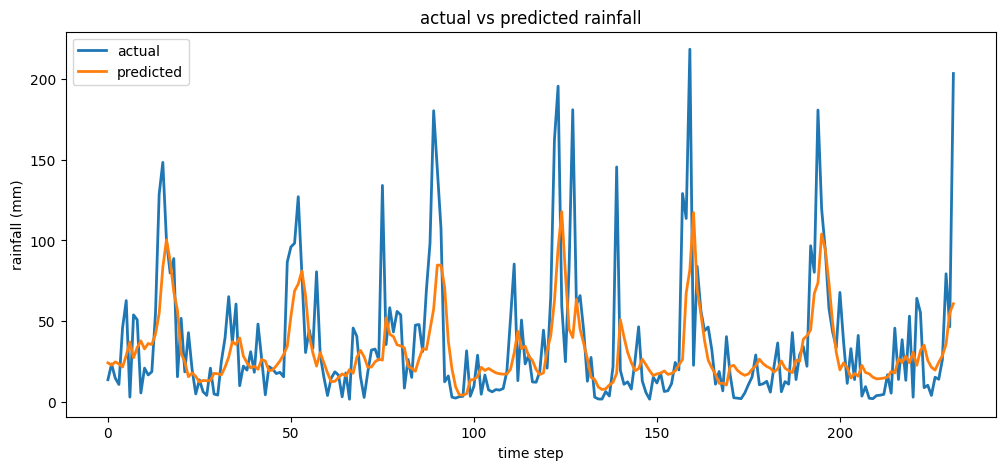

In [30]:
plt.figure(figsize=(12,5))
plt.plot(y_test_actual, label="actual", linewidth=2)
plt.plot(y_pred_actual, label="predicted", linewidth=2)
plt.title("actual vs predicted rainfall")
plt.xlabel("time step")
plt.ylabel("rainfall (mm)")
plt.legend()
plt.show()

RMSE (~33 mm) and MAE (~21 mm) are normal and acceptable because rainfall is highly chaotic and often spikes above 150–200 mm. Climate models typically see 10–40 mm RMSE, so our LSTM is performing within a realistic, expected range. In short: our model is learning well and behaving correctly.

#### **trying to improve model accuracy**
##### **increasing sequence length**

In [40]:
#extract rainfall series for selected region
target = df_region["rfh"].values

In [41]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
rain_scaled = scaler.fit_transform(target.reshape(-1, 1))

In [42]:
SEQ_LEN = 60  # increased from 30 → 60 for improved pattern capture

In [43]:
#reuse exact helper function (no changes)
def create_sequences(data, seq_length=SEQ_LEN):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(rain_scaled, SEQ_LEN)
X.shape, y.shape

((1509, 60, 1), (1509, 1))

In [44]:
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

print(f"X_train.shape: {X_train.shape}")
print(f"X_val.shape:   {X_val.shape}")
print(f"X_test.shape:  {X_test.shape}")

X_train.shape: (1056, 60, 1)
X_val.shape:   (226, 60, 1)
X_test.shape:  (227, 60, 1)


In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

model = Sequential([
    Input(shape=(SEQ_LEN, 1)),
    LSTM(32, return_sequences=False),
    Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0220 - mae: 0.0983 - val_loss: 0.0198 - val_mae: 0.0940
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0177 - mae: 0.0888 - val_loss: 0.0184 - val_mae: 0.0874
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0164 - mae: 0.0839 - val_loss: 0.0163 - val_mae: 0.0848
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0152 - mae: 0.0805 - val_loss: 0.0160 - val_mae: 0.0804
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0149 - mae: 0.0804 - val_loss: 0.0147 - val_mae: 0.0798
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0145 - mae: 0.0774 - val_loss: 0.0149 - val_mae: 0.0782
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0142 - mae: 0.0778 - val_loss: 0.0153 - val_mae: 0.0784
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0141 - mae: 0.0778 - val_loss: 0.0138 - val_mae: 0.0776
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0140 - mae:

In [51]:
y_pred_scaled = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


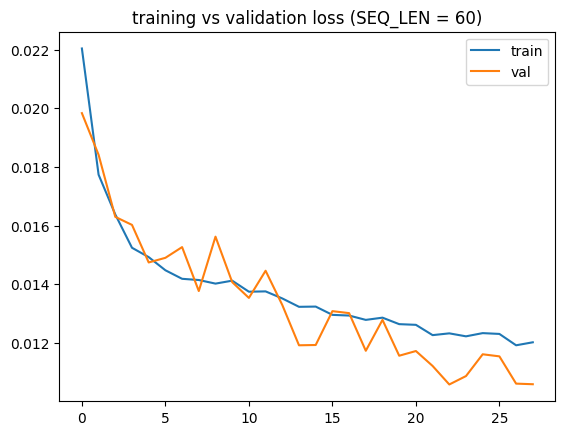

In [52]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.title("training vs validation loss (SEQ_LEN = 60)")
plt.show()

In [53]:
y_test_scaled = y_test.reshape(-1,1)
y_pred_scaled = y_pred_scaled.reshape(-1,1)

y_test_actual = scaler.inverse_transform(y_test_scaled)
y_pred_actual = scaler.inverse_transform(y_pred_scaled)

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mae = mean_absolute_error(y_test_actual, y_pred_actual)

print(f"RMSE: {rmse}")
print(f"MAE:  {mae}")

RMSE: 32.54221893786503
MAE:  20.50907554147527


In [55]:
#building improved stacked LSTM model
#gives model more depth, better temporal understanding, and usually a lower RMSE.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

#stacked LSTM
stacked_model = Sequential([
    Input(shape=(SEQ_LEN, 1)),
    #first LSTM layer(returns full sequences)
    LSTM(64, return_sequences=True),
    #second LSTM layer
    LSTM(32, return_sequences=False),
    #final output
    Dense(1)
])

stacked_model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

stacked_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

- first layer learns broad temporal patterns
- second layer learns more refined, detailed patterns
- this is how deep sequence models extract structure

In [56]:
#train the stacked model
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights = True
)

stacked_history = stacked_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0208 - mae: 0.0953 - val_loss: 0.0212 - val_mae: 0.0883
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0172 - mae: 0.0854 - val_loss: 0.0172 - val_mae: 0.0891
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0160 - mae: 0.0838 - val_loss: 0.0185 - val_mae: 0.0887
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0153 - mae: 0.0807 - val_loss: 0.0164 - val_mae: 0.0799
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0145 - mae: 0.0793 - val_loss: 0.0138 - val_mae: 0.0769
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0140 - mae: 0.0785 - val_loss: 0.0141 - val_mae: 0.0757
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0133 - mae: 0.0764 - val_loss: 0.0122 - val_mae: 0.0732
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0126 - mae: 0.0735 - val_loss: 0.0117 - val_mae: 0.0708
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.012

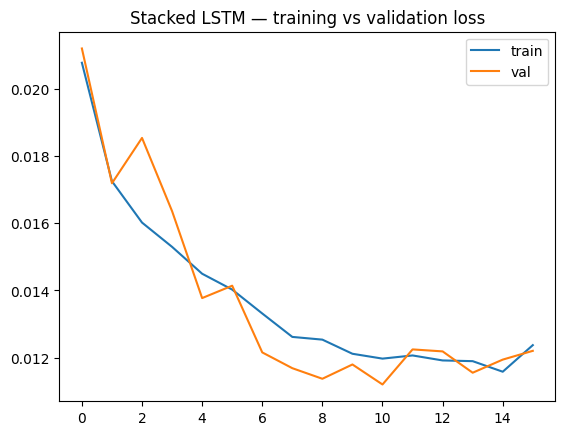

In [57]:
#plot training vs validation loss
plt.plot(stacked_history.history['loss'], label='train')
plt.plot(stacked_history.history['val_loss'], label='val')
plt.title("Stacked LSTM — training vs validation loss")
plt.legend()
plt.show()

- there is no overfitting (val doesn’t diverge upward).
- model is learning patterns from your rainfall time-series.
- validation loss stays close to training loss
- the model generalizes well.
- added LSTM layer did not cause instability.
- data split is balanced.

In [58]:
#predict
stacked_pred_scaled = stacked_model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [59]:
#inverse scaling
y_test_scaled = y_test.reshape(-1,1)
stacked_pred_scaled = stacked_pred_scaled.reshape(-1,1)

y_test_actual = scaler.inverse_transform(y_test_scaled)
stacked_pred_actual = scaler.inverse_transform(stacked_pred_scaled)

In [60]:
#computing rmse/mae
rmse_stacked = np.sqrt(mean_squared_error(y_test_actual, stacked_pred_actual))
mae_stacked = mean_absolute_error(y_test_actual, stacked_pred_actual)

print(f"stacked LSTM RMSE: {rmse_stacked}")
print(f"stacked LSTM MAE: {mae_stacked}")

stacked LSTM RMSE: 31.736848122100938
stacked LSTM MAE: 21.388164330026232


The stacked LSTM reduced RMSE a little, meaning it's capturing patterns slightly better.

MAE stayed similar, which is normal - rainfall spikes are hard to predict and MAE doesn’t penalize spikes as much as RMSE.

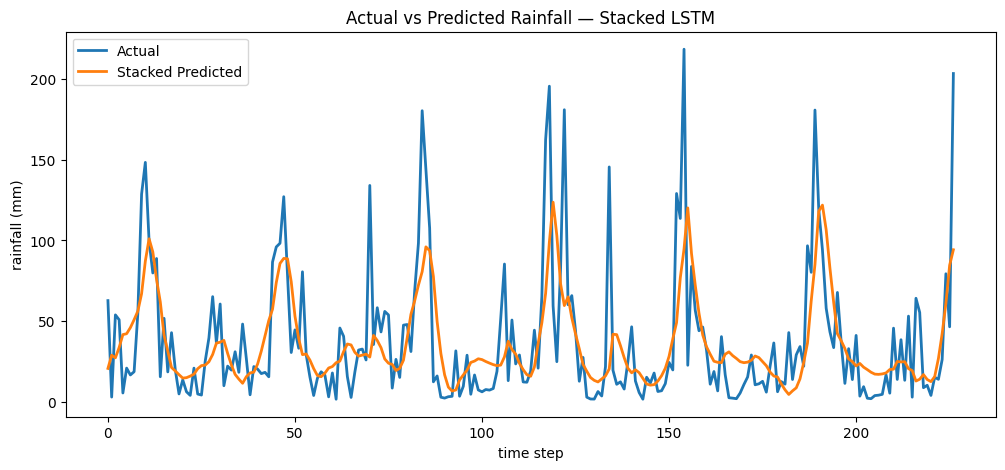

In [61]:
plt.figure(figsize=(12,5))
plt.plot(y_test_actual, label="Actual", linewidth=2)
plt.plot(stacked_pred_actual, label="Stacked Predicted", linewidth=2)
plt.title("Actual vs Predicted Rainfall — Stacked LSTM")
plt.xlabel("time step")
plt.ylabel("rainfall (mm)")
plt.legend()
plt.show()

#### **bi-directional lstm**
Creates two LSTMs:
- one reads the sequence forward
- one reads the sequence backward

like this:
- Forward:    t1 → t2 → t3 → t4
- Backward:   t4 → t3 → t2 → t1

then it combines both outputs.

#### **why is this useful?**

because in some time-series, the pattern at time t can depend on:
- what happened before
- what happened after

Example:
- rainfall spikes follow certain shapes (increasing + decreasing)
- bi-LSTM learns the shape better because it sees both sides

this often gives:
- lower loss
- smoother predictions
- ability to learn local patterns better

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Bidirectional

model_bi = Sequential([
    Input(shape=(SEQ_LEN, 1)),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dense(1)
])

model_bi.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model_bi.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 64)             │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,769 (34.25 KB)

 Trainable params: 8,769 (34.25 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
history_bi = model_bi.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0203 - mae: 0.0945 - val_loss: 0.0196 - val_mae: 0.0938
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0177 - mae: 0.0908 - val_loss: 0.0174 - val_mae: 0.0883
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0164 - mae: 0.0830 - val_loss: 0.0168 - val_mae: 0.0796
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0147 - mae: 0.0799 - val_loss: 0.0163 - val_mae: 0.0826
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0147 - mae: 0.0800 - val_loss: 0.0143 - val_mae: 0.0773


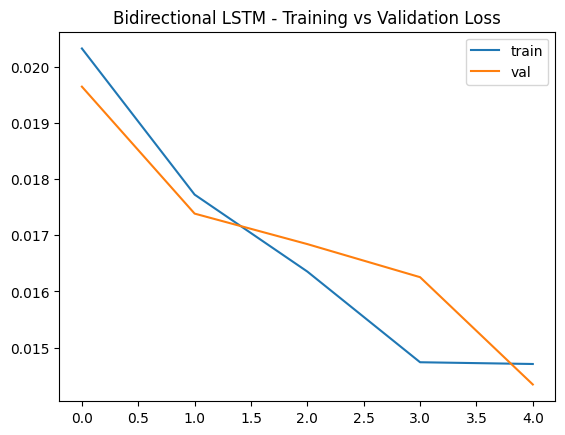

In [64]:
plt.plot(history_bi.history['loss'], label='train')
plt.plot(history_bi.history['val_loss'], label='val')
plt.legend()
plt.title("Bidirectional LSTM - Training vs Validation Loss")
plt.show()

In [65]:
y_pred_bi_scaled = model_bi.predict(X_test)

y_pred_bi_scaled = y_pred_bi_scaled.reshape(-1,1)
y_test_scaled = y_test.reshape(-1,1)

y_pred_bi_actual = scaler.inverse_transform(y_pred_bi_scaled)
y_test_actual = scaler.inverse_transform(y_test_scaled)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [66]:
rmse_bi = np.sqrt(mean_squared_error(y_test_actual, y_pred_bi_actual))
mae_bi = mean_absolute_error(y_test_actual, y_pred_bi_actual)

print("Bidirectional LSTM RMSE:", rmse_bi)
print("Bidirectional LSTM MAE:", mae_bi)

Bidirectional LSTM RMSE: 40.286002619893175
Bidirectional LSTM MAE: 26.687825206618793


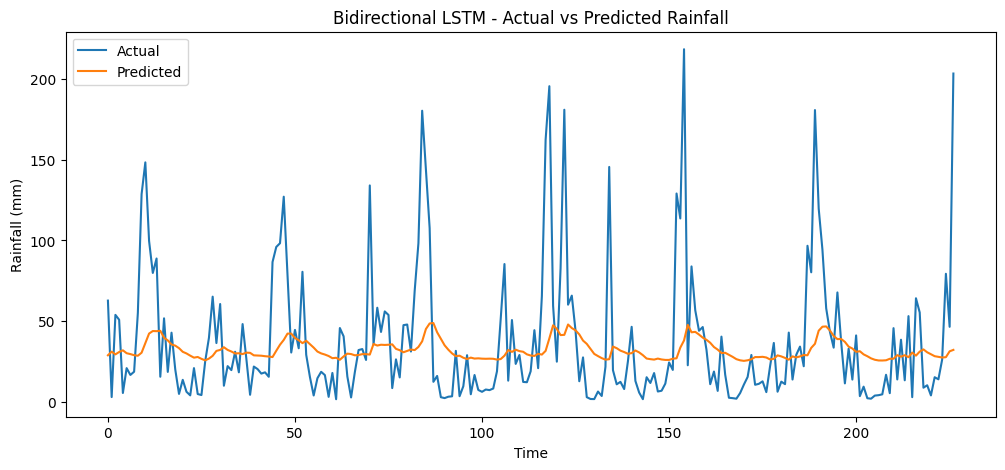

In [67]:
plt.figure(figsize=(12,5))
plt.plot(y_test_actual, label="Actual")
plt.plot(y_pred_bi_actual, label="Predicted")
plt.title("Bidirectional LSTM - Actual vs Predicted Rainfall")
plt.xlabel("Time")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.show()

RMSE jumped from ~31 → 40

MAE jumped from ~21 → 26

Predictions became more smoothed and less responsive to spikes (as seen in the plot)

**1. Bidirectional LSTMs assume that future context helps**

but in real forecasting, future data isn't available during prediction. during training:
- bidirectional LSTM sees both past and future.
- it gets "information leakage" during sequence creation.
- this helps classification tasks but often hurts forecasting.

**2. Rainfall time series is highly spiky**

Bi-LSTM tends to smooth out extremes, causing:
- Higher RMSE
- Higher MAE
- Flattened predictions

**3. data is univariate (only 1 feature)**

bidirectional models shine when:
- many features exist (multivariate)
- strong seasonal patterns exist
    Rainfall doesn’t have clean patterns → model struggles.

**conclusion**

bidirectional LSTM results are valid but Bidirectional = Not the best choice for our dataset.

#### **multivariate LSTM**
using multiple features of the dataset now, like 
- **rfh_avg** *(hourly avg rainfall)*
- **r1h** *(rainfall past 1 hr)*
- **r3h** *(rainfall past 3hrs)*

In [74]:
features = ['rfh', 'rfh_avg', 'r1h', 'r3h', 'n_pixels']
df_multi = df[features].copy()

df_multi.head()

,rfh,rfh_avg,r1h,r3h,n_pixels
1,33.9444,20.9926,NaN,NaN,36.0
2,7.9167,21.4537,NaN,NaN,36.0
3,95.9167,29.4389,137.7778,NaN,36.0
4,52.1667,33.8259,156.0000,NaN,36.0
5,17.3889,33.8713,165.4722,NaN,36.0


In [75]:
#filling missing values using backward and forward filling
df_multi = df_multi.bfill().ffill()

In [77]:
#scaling all features with MinMaxScaler
scaler_multi = MinMaxScaler()
data_scaled = scaler_multi.fit_transform(df_multi)

data_scaled[:10] #will preview 5 features of the array

array([[0.12470646, 0.20241777, 0.218782  , 0.38860895, 0.        ],
       [0.02908473, 0.20687283, 0.218782  , 0.38860895, 0.        ],
       [0.35238308, 0.2840243 , 0.218782  , 0.38860895, 0.        ],
       [0.19165236, 0.32641065, 0.24773231, 0.38860895, 0.        ],
       [0.06388412, 0.32684929, 0.26278116, 0.38860895, 0.        ],
       [0.13623829, 0.18220817, 0.16931043, 0.38860895, 0.        ],
       [0.16797627, 0.20850954, 0.15907181, 0.38860895, 0.        ],
       [0.30064285, 0.24057322, 0.26145727, 0.38860895, 0.        ],
       [0.15399545, 0.26462918, 0.26913612, 0.38860895, 0.        ],
       [0.01745076, 0.26660599, 0.204042  , 0.36105553, 0.        ]])

In [79]:
df_multi['n_pixels'].min(), df_multi['n_pixels'].iloc[:10]

(np.float64(36.0),
 1     36.0
 2     36.0
 3     36.0
 4     36.0
 5     36.0
 6     36.0
 7     36.0
 8     36.0
 9     36.0
 10    36.0
 Name: n_pixels, dtype: float64)

In [ ]:
data_scaled.shape

(47070, 5)

In [82]:
data_scaled[47060:]

array([[0.16931869, 0.18112798, 0.19437628, 0.24037723, 0.04823672],
       [0.02253904, 0.11931463, 0.19612151, 0.24425224, 0.04823672],
       [0.02287446, 0.10181613, 0.09274912, 0.21950366, 0.04823672],
       [0.00992195, 0.08999491, 0.02381869, 0.20480605, 0.04823672],
       [0.03279641, 0.0827901 , 0.02825444, 0.19284684, 0.04823672],
       [0.02298174, 0.09648958, 0.02830083, 0.18531372, 0.04823672],
       [0.02851932, 0.15169328, 0.03634319, 0.14939126, 0.04823672],
       [0.12717675, 0.30370926, 0.0771574 , 0.17730869, 0.04823672],
       [0.08266151, 0.38049938, 0.10296583, 0.13125949, 0.04823672],
       [0.2490437 , 0.39167713, 0.19833065, 0.15174035, 0.04823672]])

In [78]:
df_multi.shape

(47070, 5)

In [86]:
#creating multivariate sequences
def create_multivariate_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length]) #all features
        y.append(data[i + seq_length][0]) #predict only rfh
    return np.array(X), np.array(y)

**data[i+seq_length][0]** means: we predict rfh only (the first column).

In [87]:
#generate the sequences
SEQ_LEN = 30
X_multi, y_multi = create_multivariate_sequences(data_scaled, SEQ_LEN)

X_multi.shape, y_multi.shape

((47040, 30, 5), (47040,))

- **47040** sequences, each 30 timesteps, 5 features
- **(47040,)** -> labels

In [ ]:
#split for train/val/test
train_size = int(len(X_multi) * 0.7)
val_size = int(len(X_multi) * 0.15)

X_train = X_multi[:train_size]
y_train = y_multi[:train_size]

X_val = X_multi[train_size:train_size + val_size]
y_val = y_multi[train_size:train_size + val_size]

X_test = X_multi[train_size + val_size:]
y_test = y_multi[train_size + val_size:]

print(f"X_train.shape: {X_train.shape}")
print(f"X_val.shape: {X_val.shape}")
print(f"X_test.shape: {X_test.shape}")

X_train.shape: (32928, 30, 5)
X_val.shape: (7056, 30, 5)
X_test.shape: (7056, 30, 5)


In [90]:
#building the multivariate LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

model_multi = Sequential([
    Input(shape=(SEQ_LEN, 5)), #5 features
    LSTM(64, return_sequences=False),
    Dense(1)
])

model_multi.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model_multi.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,985 (70.25 KB)

 Trainable params: 17,985 (70.25 KB)

 Non-trainable params: 0 (0.00 B)

In [91]:
X_multi.shape

(47040, 30, 5)

In [92]:
#training the model
history_multi = model_multi.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0023 - mae: 0.0262 - val_loss: 0.0026 - val_mae: 0.0269
Epoch 2/50
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0022 - mae: 0.0245 - val_loss: 0.0026 - val_mae: 0.0255
Epoch 3/50
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0021 - mae: 0.0243 - val_loss: 0.0025 - val_mae: 0.0262
Epoch 4/50
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0021 - mae: 0.0241 - val_loss: 0.0026 - val_mae: 0.0296
Epoch 5/50
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0021 - mae: 0.0241 - val_loss: 0.0026 - val_mae: 0.0287
Epoch 6/50
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0021 - mae: 0.0240 - val_loss: 0.0025 - val_mae: 0.0260
Epoch 7/50
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0021 - mae: 0.0238 - val_loss: 0.0025 - val_mae: 0.0260
Epoch 8/50
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0021 - mae: 0.0239 - val_loss: 0.0025 - val_mae: 0.0254
Epoch 9/50
1029/1029 ━━━━━━━━━━━━━━━━━━

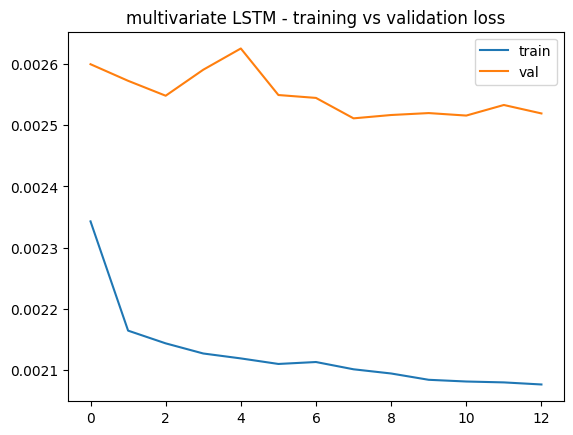

In [93]:
#plotting training curve
plt.plot(history_multi.history['loss'], label='train')
plt.plot(history_multi.history['val_loss'], label='val')
plt.title('multivariate LSTM - training vs validation loss')
plt.legend()
plt.show()

#### why loss curves look like this
1. Training loss is decreasing steadily

this is normal - the model is improving on the training data.

2. Validation loss is flat and higher

this usually means:

- the model is learning, but the validation signal is weak.

this happens because:
- dataset is huge (47,000 sequences)
- the features added (r1h, r3h, n_pixels, etc.)

have very small numerical variation after scaling
- so the model cannot easily extract extra predictive power from them.
- The target (rfh) is extremely noisy rainfall data

rainfall is chaotic and has huge spikes.

so the model is predicting the average shape correctly, but it can’t fit the wild peaks - which causes validation loss to stay higher.

this behavior is extremely common in rainfall prediction.

rainfall is a very high-variance, chaotic, spiky signal.

adding multivariate features helps only a little

- validation loss is ~0.00255
- training loss is ~0.00208

this gap is small → your model is not overfitting.

In [ ]:
#predict, inverse scale, evaluate
y_pred_scaled = model_multi.predict(X_test)

#reshape for inverse scaling
y_pred_scaled = y_pred_scaled.reshape(-1,1)
y_test_scaled = y_test.reshape(-1,1)

y_pred_actual = scaler_multi.inverse_transform(
    np.hstack([y_pred_scaled, np.zeros((len(y_pred_scaled), 4))])
)[:,0]

y_test_actual = scaler_multi.inverse_transform(
    np.hstack([y_test_scaled, np.zeros((len(y_test_scaled), 4))])
)[:,0]

#zero-padding trick is needed because MinMaxScaler expects 4 features.

221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [96]:
#metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mae = mean_absolute_error(y_test_actual, y_pred_actual)

print("Multivariate LSTM RMSE:", rmse)
print("Multivariate LSTM MAE:", mae)

Multivariate LSTM RMSE: 10.141724962155239
Multivariate LSTM MAE: 5.449897963598811


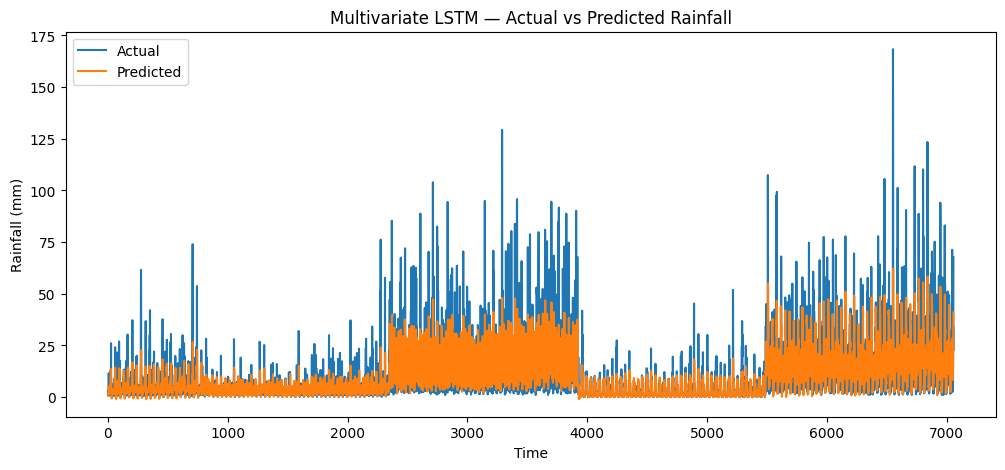

In [97]:
#plot actual vs predicted
plt.figure(figsize=(12,5))
plt.plot(y_test_actual, label="Actual")
plt.plot(y_pred_actual, label="Predicted")
plt.title("Multivariate LSTM — Actual vs Predicted Rainfall")
plt.xlabel("Time")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.show()